In [1]:
import sys
import pickle
import numpy as np
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()  # if not use with this line, "AttributeError: 'int' object has no attribute 'value'" 
# tf.disable_eager_execution()
import PIL.Image
%matplotlib inline
import matplotlib.pyplot as plt

##### Set the path of code folder containing GANSim codes

In [2]:
new_path = r'/home/users/suihong/11-GenerativeGeomodelling_GANs_MPS_Comparison/2DPointBar/2_GANSimTraining/' 
sys.path.append(new_path)

### 1. Load test dataset

#### Set the path to data directory; this directory includes two datasets: "trainingdata" and "testdata"

In [3]:
data_dir_test = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/PreparedDataset/'

In [5]:
# Initialize TensorFlow session.
tf.InteractiveSession()

import dataset

test_set = dataset.load_dataset(data_dir=data_dir_test, verbose=True, tfrecord_dir='TestData', 
                                 cond_label = True, cond_well = False, cond_prob = False,
                                 well_enlarge = False, shuffle_mb = 0, prefetch_mb = 0)

# loaded labels (global features) have been normalized into -1 to 1
facies_label_thick_dict = test_set.get_minibatch_np(minibatch_size = 1000, lod = 0)  
facies_test = facies_label_thick_dict['real']
labels_test = facies_label_thick_dict['label']

# Denormalize the global features back into its orginal range 
pb_cf_ratio_test = (labels_test[:,0] /2 +0.5) * (2-0.2) + 0.2  # point bar-to-channel fill ratio
fp_prop_test = (labels_test[:,1] / 2 + 0.5) * (0.82- 0.5) + 0.5   # floodplain proportion

print(facies_test.shape)
print(pb_cf_ratio_test.shape)
print(fp_prop_test.shape)

Streaming data using dataset.TFRecordDataset...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.
Dataset shape = [1, 64, 64]
Dynamic range = [0, 2]
Label size    = 0
(1000, 1, 64, 64)
(1000,)
(1000,)


(array([  1.,   0.,   1.,   1.,   1.,   1.,   2.,   5.,   3.,   3.,   6.,
          9.,  10.,  18.,  19.,  22.,  22.,  29.,  42.,  46.,  62.,  58.,
         70.,  85.,  75.,  81., 122., 102.,  82.,  22.]),
 array([0.43652344, 0.44934896, 0.46217448, 0.475     , 0.4878255 ,
        0.50065106, 0.51347655, 0.5263021 , 0.5391276 , 0.55195314,
        0.5647786 , 0.5776042 , 0.59042966, 0.6032552 , 0.6160807 ,
        0.62890625, 0.6417318 , 0.6545573 , 0.66738284, 0.6802083 ,
        0.6930339 , 0.70585936, 0.7186849 , 0.7315104 , 0.74433595,
        0.75716144, 0.769987  , 0.7828125 , 0.795638  , 0.8084635 ,
        0.82128906], dtype=float32),
 <a list of 30 Patch objects>)

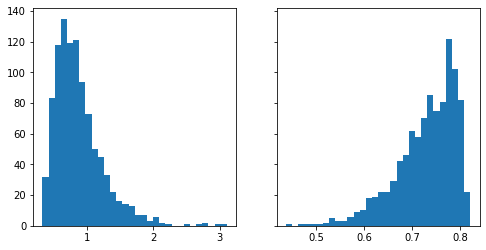

In [6]:
# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=2, nrows=1, sharey='row')
fig.set_size_inches(8, 4, forward=True)

axes[0].hist(pb_cf_ratio_test, bins = 30)
axes[1].hist(fp_prop_test, bins = 30)


### 2. Train and load trained conditional generator

In [7]:
GANSim_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/GANSim_cond_gf/'
GANSim_name = 'network-snapshot-015360.pkl' 

In [8]:
tf.InteractiveSession()

import dataset

with tf.device('/gpu:0'):   
    # Import networks.
    with open(GANSim_dir + GANSim_name, 'rb') as file:
        G_gansim, D_Gansim, Gs_Gansim = pickle.load(file)
    

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


### 3. Facies geomodel prediction based on trained generator and evaluation

*Assume the flood plain facies proportion and the point bar to channel fill ratio are 0.74 and 1.14*


In [9]:
fp_prop_cond = 0.74
pb_cf_ratio_cond = 1.14

# normalize the two global features into a range of [-1, 1] which is used in training.
pb_cf_ratio_cond = ((pb_cf_ratio_cond - 0.2) / 1.8 - 0.5) * 2
fp_prop_cond = ((fp_prop_cond - 0.5) / 0.32 - 0.5) * 2
labels_cond = np.concatenate((np.array([pb_cf_ratio_cond]), np.array([fp_prop_cond])))[np.newaxis, :]
print(labels_cond.shape)


(1, 2)


In [10]:
import time

TotalModel_no_cond_sim = 200
latents_cond_sim = np.random.RandomState(412).randn(TotalModel_no_cond_sim, 8, 4, 4)
labels_cond_sim = np.tile(np.expand_dims(np.expand_dims(labels_cond, axis = -1), axis = -1), (TotalModel_no_cond_sim, 1, 64, 64))
print(labels_cond_sim.shape)

wellfacies_cond_sim = np.zeros([TotalModel_no_cond_sim, 0, 64, 64])
prob_cond_sim = np.zeros((TotalModel_no_cond_sim, 0, 64, 64))  #probimgs_test

# generation of facies indicator models from the trained generator
start_time = time.time()
fakemodel_indicators_cond_sim = Gs_Gansim.run(latents_cond_sim, labels_cond_sim, wellfacies_cond_sim, prob_cond_sim)
print(fakemodel_indicators_cond_sim.shape)

# facies models through argmax
fakemodels_cond_sim = np.expand_dims(np.argmax(fakemodel_indicators_cond_sim, axis = 1), axis = 1)
end_time = time.time()

print(fakemodels_cond_sim.shape)
# Output the execution time 
print("Execution Time: {:.4f} seconds".format((end_time - start_time) / TotalModel_no_cond_sim))


(200, 2, 64, 64)
(200, 4, 64, 64)
(200, 1, 64, 64)
Execution Time: 0.0156 seconds


In [11]:
# Calculate the global features for the generated facies models

fp_prop_gansim = np.mean(fakemodel_indicators_cond_sim[:, 0], axis = (1, 2))
md_prop_gansim = np.mean(fakemodel_indicators_cond_sim[:, 1], axis = (1, 2))
cf_prop_gansim = np.mean(fakemodel_indicators_cond_sim[:, 2], axis = (1, 2))
sd_prop_gansim = np.mean(fakemodel_indicators_cond_sim[:, 3], axis = (1, 2))
# point bar (lump mud drape and sand together as one) to channel fill ratio
pb_cf_ratio_gansim = (md_prop_gansim + sd_prop_gansim) / cf_prop_gansim   

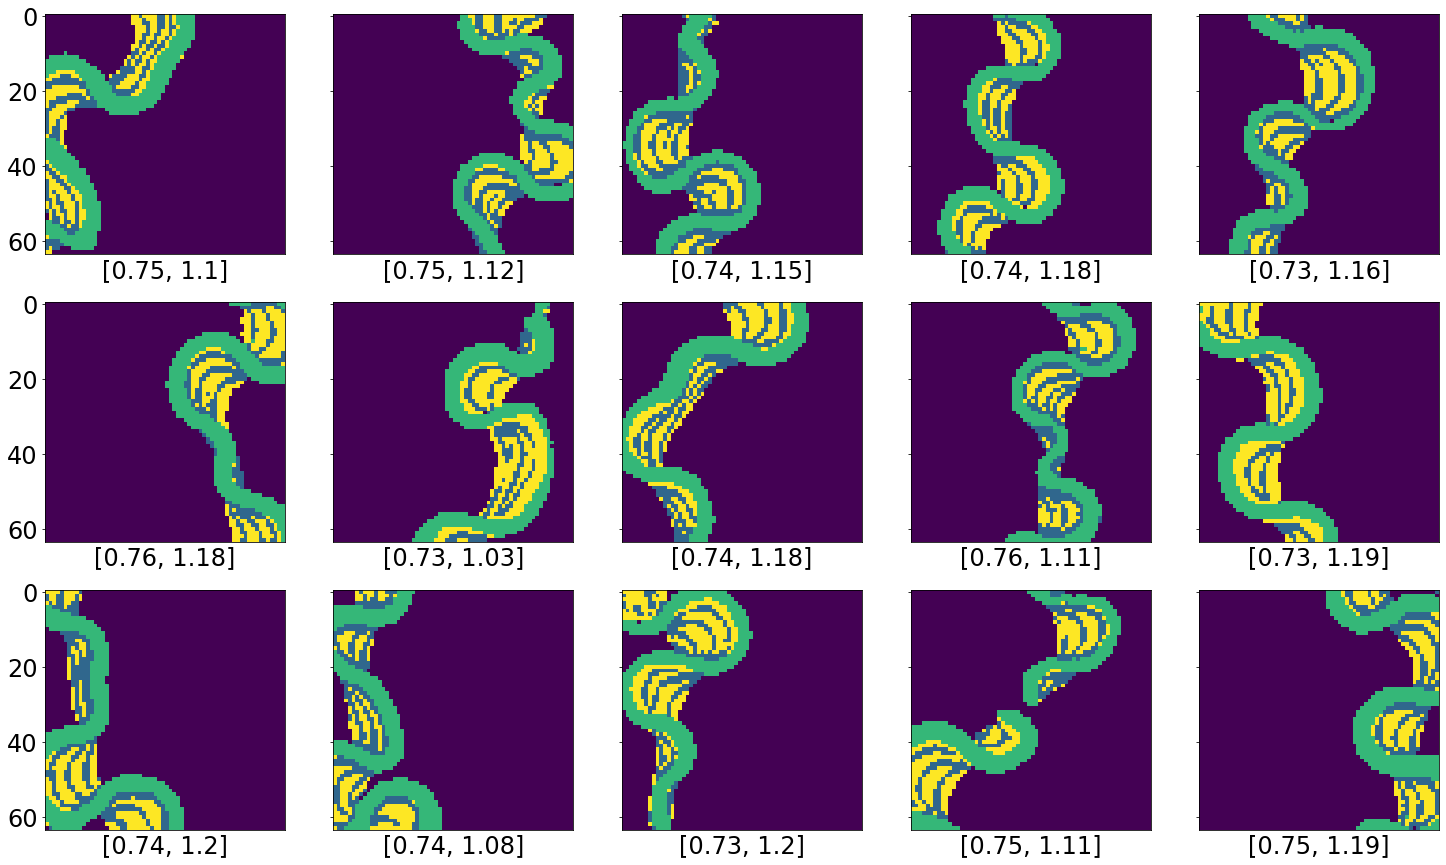

In [12]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

for j in range(5):
    ax[0, j].imshow(fakemodels_cond_sim[j,0].astype(np.float32))  
    ax[0, j].set_xlabel(f'[{str(round(fp_prop_gansim[j], 2))}, {str(round(pb_cf_ratio_gansim[j], 2))}]') 
for j in range(5):
    ax[1, j].imshow(fakemodels_cond_sim[j+15,0].astype(np.float32))  
    ax[1, j].set_xlabel(f'[{str(round(fp_prop_gansim[j+15], 2))}, {str(round(pb_cf_ratio_gansim[j+15], 2))}]') 
for j in range(5):
    ax[2, j].imshow(fakemodels_cond_sim[j+25,0].astype(np.float32))  
    ax[2, j].set_xlabel(f'[{str(round(fp_prop_gansim[j+25], 2))}, {str(round(pb_cf_ratio_gansim[j+25], 2))}]') 
    ax[2, j].set_xticks([])  # Remove x-axis markers
    
#plt.savefig(GANSim_dir + "_15360_cond_random_15FaciesMaps_1.png", dpi=200)    

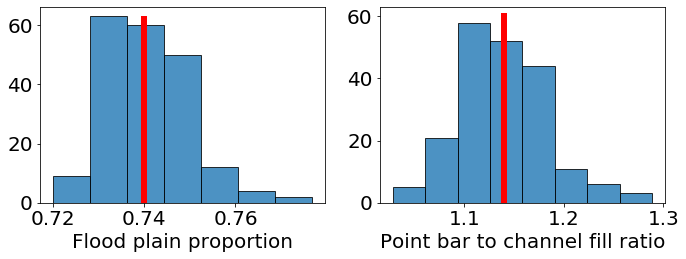

In [13]:
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 4)

# Plot the histogram with probability density   range = (18, 25), 
ax[0].hist(fp_prop_gansim, bins=7, alpha=0.8, histtype='bar', ec='black')  # Change color and transparency if needed
# Add a bolder vertical line
ax[0].plot([0.74, 0.74], [0, 62], 'r-', linewidth=6)
ax[0].set_xlabel(f'Flood plain proportion')

# Plot the histogram with probability density   , range = (0.55, 0.72)
ax[1].hist(pb_cf_ratio_gansim, bins=8, alpha=0.8, histtype='bar', ec='black')  # Change color and transparency if needed
# Add a bolder vertical line
ax[1].plot([1.14, 1.14], [0, 60], 'r-', linewidth=6)
ax[1].set_xlabel(f'Point bar to channel fill ratio')

# Adjust space between subplots
plt.subplots_adjust(wspace=0.25)  # Increase this value for more space

# Use tight layout to prevent labels from being cut off
plt.tight_layout()

#plt.savefig(GANSim_dir + "_13440_cond_Geometrical histograms.jpg", dpi=80)       

### 4. Comparison of predicted facies models from post-GANs, GANSim, and MPS

*Load MPS results of direct sampling method*

In [14]:
def swap_code_1_3(orig_facies):
    new_facies = np.where((orig_facies == 1) | (orig_facies == 3), 4 - orig_facies, orig_facies)
    return new_facies

import os

ds_uncond_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/MPS_unc/DS_unc/'

n = 15
t = 0.10
t = f"{t:.3f}"
f = 1.00
f = f"{f:.2f}"
ds_folder_name = 'n_' + str(n) + '_t_' + str(t) + '_f_' + str(f)
ds_file_path = os.path.join(ds_uncond_dir, ds_folder_name, 'all_sim_results.npy')
ds_mps_results = np.load(ds_file_path)
ds_mps_results = swap_code_1_3(ds_mps_results)

ds_fp_indc = np.where(ds_mps_results == 0, 1, 0)
ds_md_indc = np.where(ds_mps_results == 1, 1, 0)
ds_cf_indc = np.where(ds_mps_results == 2, 1, 0)
ds_la_indc = np.where(ds_mps_results == 3, 1, 0)

ds_pb_cf_rt = (np.mean(ds_md_indc, axis = (1, 2)) + np.mean(ds_la_indc, axis = (1, 2)))/np.mean(ds_cf_indc, axis = (1, 2))
ds_fp_prop = np.mean(ds_fp_indc, axis = (1, 2))

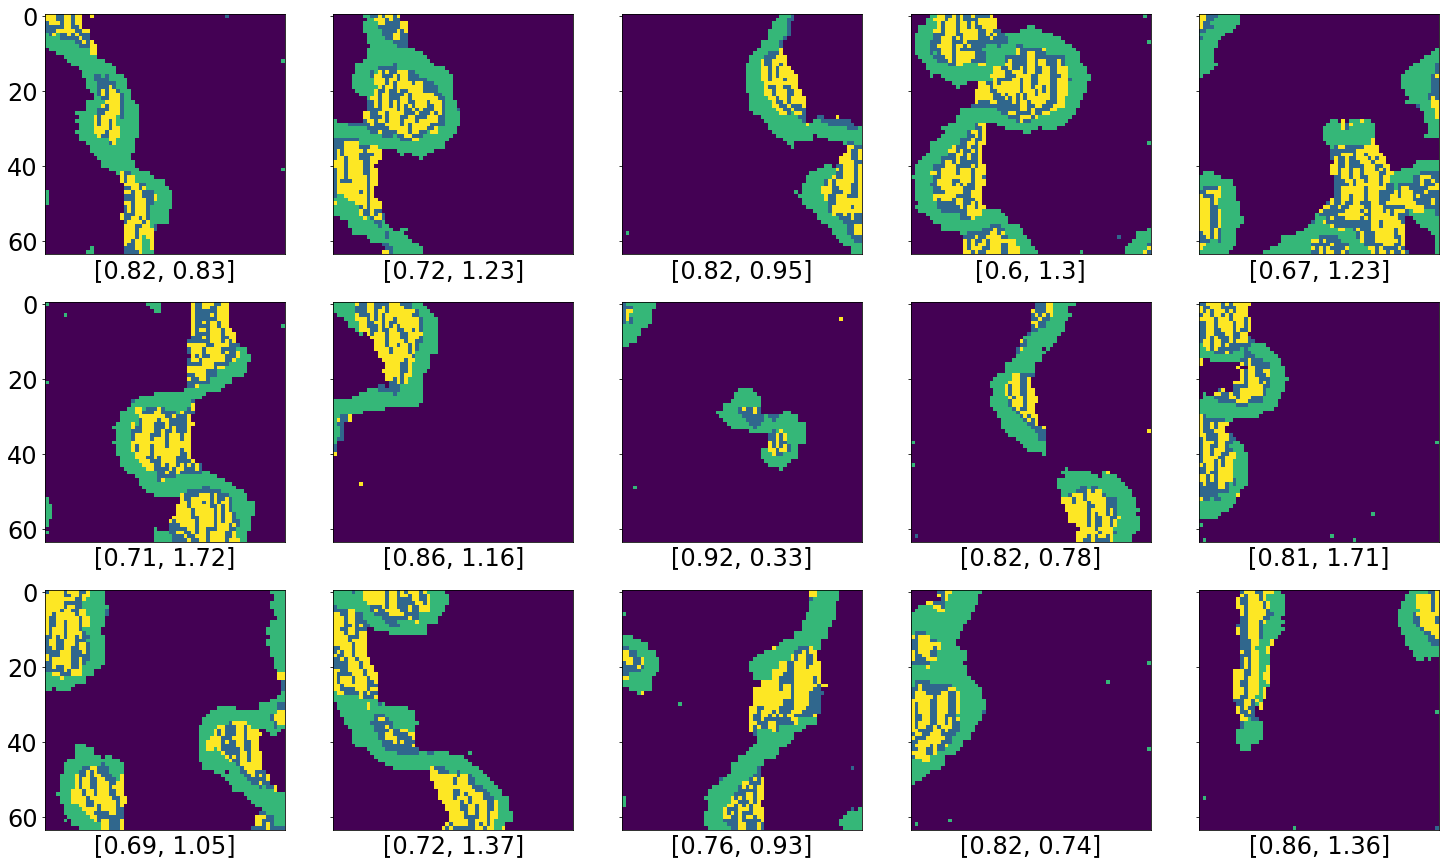

In [15]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

for j in range(5):
    ax[0, j].imshow(ds_mps_results[j].astype(np.float32))  
    ax[0, j].set_xlabel(f'[{str(round(ds_fp_prop[j], 2))}, {str(round(ds_pb_cf_rt[j], 2))}]') 
for j in range(5):
    ax[1, j].imshow(ds_mps_results[j+15].astype(np.float32))  
    ax[1, j].set_xlabel(f'[{str(round(ds_fp_prop[j+15], 2))}, {str(round(ds_pb_cf_rt[j+15], 2))}]') 
for j in range(5):
    ax[2, j].imshow(ds_mps_results[j+25].astype(np.float32))  
    ax[2, j].set_xlabel(f'[{str(round(ds_fp_prop[j+25], 2))}, {str(round(ds_pb_cf_rt[j+25], 2))}]') 
    ax[2, j].set_xticks([])  # Remove x-axis markers
    

*Load MPS results of quick sampling method*

In [16]:
qs_uncond_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/MPS_unc/QS_unc/'

n = 15
k = 1
qs_folder_name = 'n_' + str(n) + '_k_' + str(k)
qs_file_path = os.path.join(qs_uncond_dir, qs_folder_name, 'all_sim_results.npy')
qs_mps_results = np.load(qs_file_path)
qs_mps_results = swap_code_1_3(qs_mps_results)

qs_fp_indc = np.where(qs_mps_results == 0, 1, 0)
qs_md_indc = np.where(qs_mps_results == 1, 1, 0)
qs_cf_indc = np.where(qs_mps_results == 2, 1, 0)
qs_la_indc = np.where(qs_mps_results == 3, 1, 0)

qs_pb_cf_rt = (np.mean(qs_md_indc, axis = (0, 1)) + np.mean(qs_la_indc, axis = (0, 1)))/np.mean(qs_cf_indc, axis = (0, 1))
qs_fp_prop = np.mean(qs_fp_indc, axis = (0, 1))

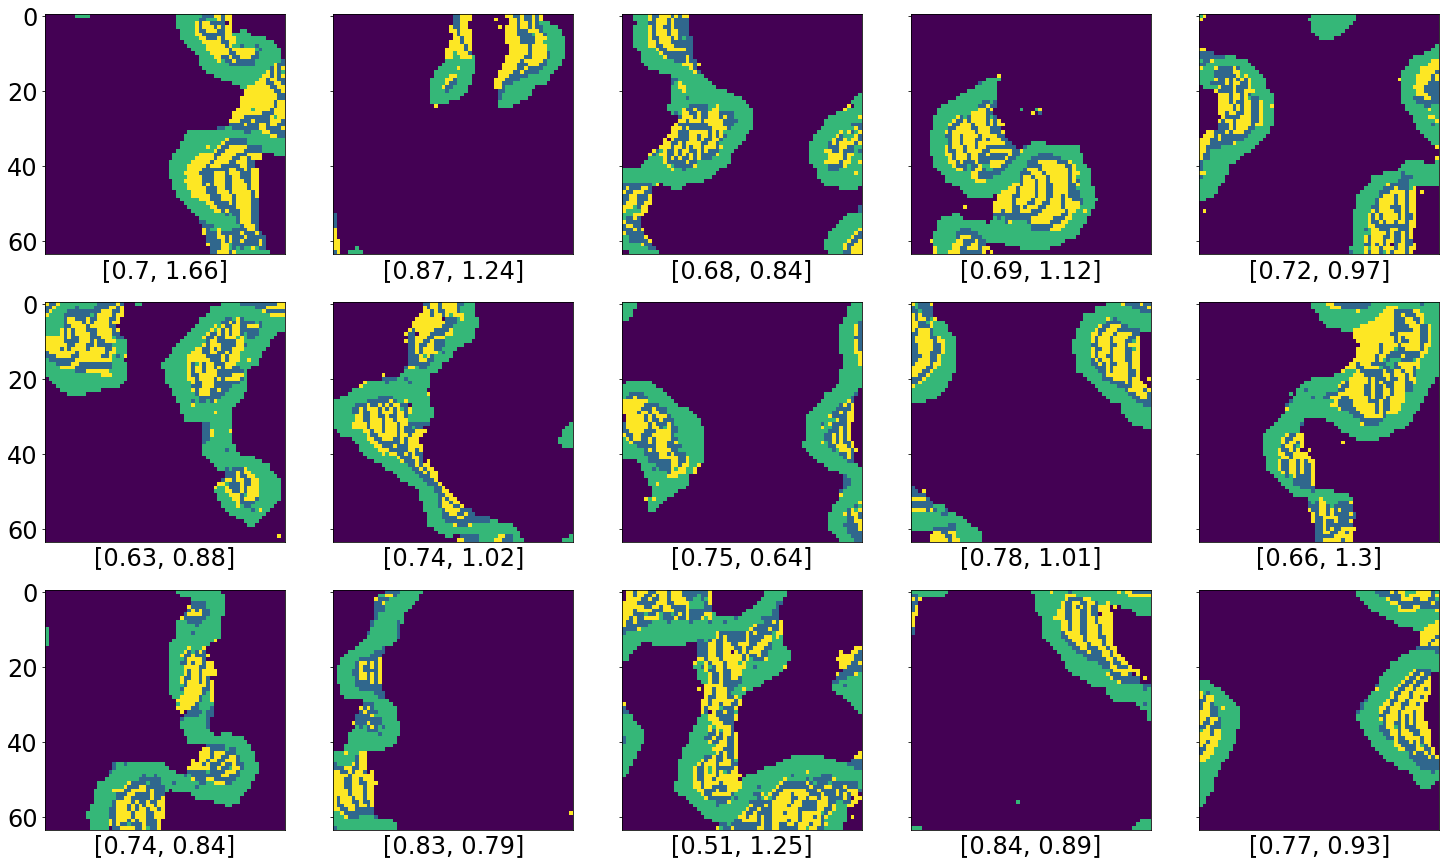

In [17]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

for j in range(5):
    ax[0, j].imshow(qs_mps_results[:, :, j].astype(np.float32))  
    ax[0, j].set_xlabel(f'[{str(round(qs_fp_prop[j], 2))}, {str(round(qs_pb_cf_rt[j], 2))}]') 
for j in range(5):
    ax[1, j].imshow(qs_mps_results[:, :, j+15].astype(np.float32))  
    ax[1, j].set_xlabel(f'[{str(round(qs_fp_prop[j+15], 2))}, {str(round(qs_pb_cf_rt[j+15], 2))}]') 
for j in range(5):
    ax[2, j].imshow(qs_mps_results[:, :, j+25].astype(np.float32))  
    ax[2, j].set_xlabel(f'[{str(round(qs_fp_prop[j+25], 2))}, {str(round(qs_pb_cf_rt[j+25], 2))}]') 
    ax[2, j].set_xticks([])  # Remove x-axis markers
    

*Load MPS results of SNESim method*

In [18]:
snesim_Filepath = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/MPS_unc/SNESIM_unc/Point_Unc_SNESIM_DifRadius'

allele=[]  # store all elements of the file. including 64*64 lists, and each list includes code for all realizations
with open (snesim_Filepath) as fl:
    for line in fl:
        eles = line.strip().split(' ')
       
        if len(eles)>=5:            
            allele.append(eles)
        
partimgs=np.array(allele, dtype=np.float32)[:, 3:].reshape(64, 64, -1).astype(np.int32)  # all imges (realizations), of shape (64,64, rlz_no)
partimgs = np.where(partimgs == 1, 3, np.where(partimgs == 3, 1, partimgs)) # exchange code of mud drape and sandy lateral accretion
partimgs = partimgs[::-1,:,:]
print(partimgs.shape)

snesim_mps_results = partimgs[:, :, 3 * 99: 4 * 99]

snesim_fp_indc = np.where(snesim_mps_results == 0, 1, 0)
snesim_md_indc = np.where(snesim_mps_results == 1, 1, 0)
snesim_cf_indc = np.where(snesim_mps_results == 2, 1, 0)
snesim_la_indc = np.where(snesim_mps_results == 3, 1, 0)

snesim_pb_cf_rt = (np.mean(snesim_md_indc, axis = (0, 1)) + np.mean(snesim_la_indc, axis = (0, 1)))/np.mean(snesim_cf_indc, axis = (0, 1))
snesim_fp_prop = np.mean(snesim_fp_indc, axis = (0, 1))


(64, 64, 690)


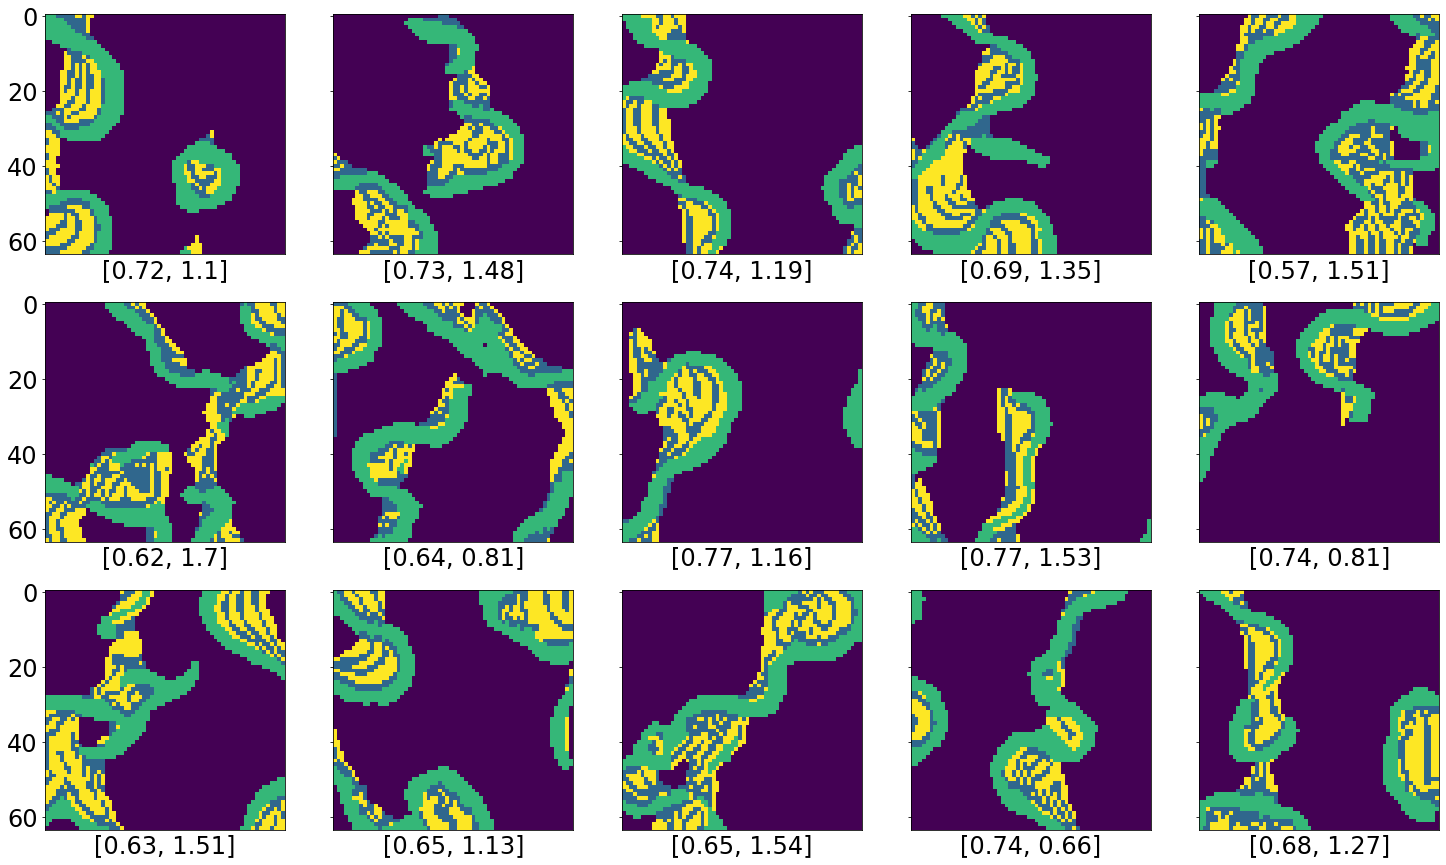

In [19]:
plt.rcParams.update({'font.size': 24})

fig, ax = plt.subplots(3, 5, sharex='col', sharey='row')
fig.set_size_inches(25, 15, forward=True)

for j in range(5):
    ax[0, j].imshow(snesim_mps_results[:, :, j].astype(np.float32))  
    ax[0, j].set_xlabel(f'[{str(round(snesim_fp_prop[j], 2))}, {str(round(snesim_pb_cf_rt[j], 2))}]') 
for j in range(5):
    ax[1, j].imshow(snesim_mps_results[:, :, j+15].astype(np.float32))  
    ax[1, j].set_xlabel(f'[{str(round(snesim_fp_prop[j+15], 2))}, {str(round(snesim_pb_cf_rt[j+15], 2))}]') 
for j in range(5):
    ax[2, j].imshow(snesim_mps_results[:, :, j+25].astype(np.float32))  
    ax[2, j].set_xlabel(f'[{str(round(snesim_fp_prop[j+25], 2))}, {str(round(snesim_pb_cf_rt[j+25], 2))}]') 
    ax[2, j].set_xticks([])  # Remove x-axis markers
    

*Load post-GANs (MCMC) results*

In [20]:
mcmc_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/MCMCForGlobalFeatureConditioning/'
mcmc_convg_info_fname =  mcmc_dir + "MCMC_Fluvial_10chainx50kiter_sig_p01.txt"

allele=[] 
with open(mcmc_convg_info_fname, 'r') as f:
    for line in f:
        eles = line.strip().split(' ')
        allele.append(eles)

converg_info = np.array(allele, dtype = float).reshape((-1, 131))
print(converg_info.shape)

converg_chains = converg_info[:, 0]
converg_times = converg_info[:, 1]
converg_dists = converg_info[:, 2]
converg_latents = converg_info[:,3:].reshape(-1, 8, 4, 4)

all_chain_dist_ord = np.argwhere(converg_dists<0.015)[:, 0]
converg_dists_all_chains = converg_dists[all_chain_dist_ord]
converg_latents_all_chains = converg_latents[all_chain_dist_ord]

sample_numb = 200
random_index = np.random.RandomState(66).permutation(converg_latents_all_chains.shape[0])[:sample_numb]
sampled_latents_MCMC = converg_latents_all_chains[random_index]
sampled_dists_MCMC = converg_dists_all_chains[random_index]

generator_dir = '/scratch/users/suihong/GANSim_vs_MPS_for_Geomodelling/0_Data/GANSim_unc/'
generator_name = 'network-snapshot-028481.pkl' 
tf.InteractiveSession()
with tf.device('/gpu:0'):   
    # Import networks.
    with open(generator_dir+generator_name, 'rb') as file:
        _, _, Gs_unc = pickle.load(file)    

labels_run = np.zeros((sample_numb, 0, 4, 4))
wellfacies_run = np.zeros((sample_numb, 0, 64, 64)) 
prob_run = np.zeros((sample_numb, 0, 64, 64)) 
fakemodel_indicators = Gs_unc.run(sampled_latents_MCMC, labels_run, wellfacies_run, prob_run)
fakemodel_mcmc = np.expand_dims(np.argmax(fakemodel_indicators, axis = 1), axis = 1)  # [N, 1, 64, 64]
    
fp_prop_mcmc = np.mean(fakemodel_indicators[:, 0], axis = (1, 2))
md_prop_mcmc = np.mean(fakemodel_indicators[:, 1], axis = (1, 2))
cf_prop_mcmc = np.mean(fakemodel_indicators[:, 2], axis = (1, 2))
sd_prop_mcmc = np.mean(fakemodel_indicators[:, 3], axis = (1, 2))
# point bar (lump mud drape and sand together as one) to channel fill ratio
pb_cf_ratio_mcmc = (md_prop_mcmc + sd_prop_mcmc) / cf_prop_mcmc   

(309657, 131)


/share/software/user/open/py-tensorflow/2.6.2_py36/lib/python3.6/site-packages/tensorflow/python/client/session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


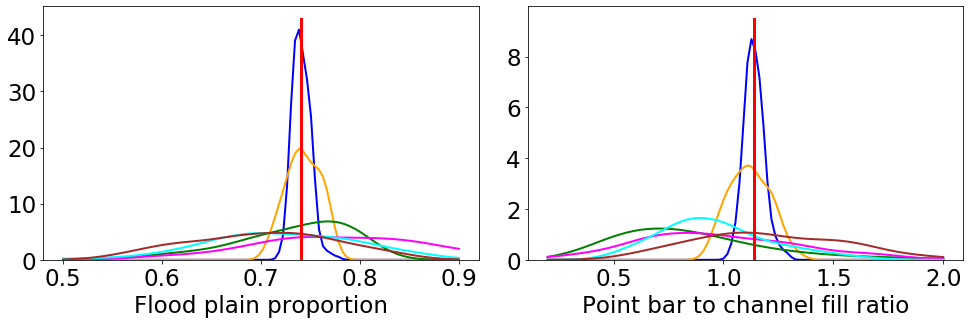

In [21]:
plt.rcParams.update({'font.size': 23})

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(14, 5)

from scipy.stats import gaussian_kde
# --- Plot for Flood Plain Proportion ---
x_range = np.linspace(0.5, 0.9, 100)

# KDEs
kde_cond_gansim = gaussian_kde(fp_prop_gansim, bw_method=0.4)
kde_mcmc = gaussian_kde(fp_prop_mcmc, bw_method=0.4)
kde_test = gaussian_kde(fp_prop_test, bw_method=0.4)
kde_ds = gaussian_kde(ds_fp_prop, bw_method=0.4)
kde_qs = gaussian_kde(qs_fp_prop, bw_method=0.4)
kde_snesim = gaussian_kde(snesim_fp_prop, bw_method=0.4)

# PDFs
ax[0].plot(x_range, kde_cond_gansim(x_range), 'blue', linewidth=2, label='cond PDF')
ax[0].plot(x_range, kde_mcmc(x_range), 'orange', linewidth=2, label='mcmc PDF')
ax[0].plot(x_range, kde_test(x_range), 'g', linewidth=2, label='test PDF')
ax[0].plot(x_range, kde_ds(x_range), 'magenta', linewidth=2, label='DS PDF')
ax[0].plot(x_range, kde_qs(x_range), 'cyan', linewidth=2, label='QS PDF')
ax[0].plot(x_range, kde_snesim(x_range), 'brown', linewidth=2, label='Snesim PDF')

# Highlighted vertical line
ax[0].plot([0.74, 0.74], [0, 43], 'r-', linewidth=3)
ax[0].set_ylim(bottom=0)
ax[0].set_xlabel('Flood plain proportion')

# --- Plot for Point Bar to Channel Fill Ratio ---
x_range = np.linspace(0.2, 2.0, 100)

# KDEs
kde_cond_gansim = gaussian_kde(pb_cf_ratio_gansim, bw_method=0.4)
kde_mcmc = gaussian_kde(pb_cf_ratio_mcmc, bw_method=0.4)
kde_test = gaussian_kde(pb_cf_ratio_test, bw_method=0.4)
kde_ds = gaussian_kde(ds_pb_cf_rt, bw_method=0.4)
kde_qs = gaussian_kde(qs_pb_cf_rt, bw_method=0.4)
kde_snesim = gaussian_kde(snesim_pb_cf_rt, bw_method=0.4)

# PDFs
ax[1].plot(x_range, kde_cond_gansim(x_range), 'blue', linewidth=2, label='cond PDF')
ax[1].plot(x_range, kde_mcmc(x_range), 'orange', linewidth=2, label='mcmc PDF')
ax[1].plot(x_range, kde_test(x_range), 'g', linewidth=2, label='test PDF')
ax[1].plot(x_range, kde_ds(x_range), 'magenta', linewidth=2, label='DS PDF')
ax[1].plot(x_range, kde_qs(x_range), 'cyan', linewidth=2, label='QS PDF')
ax[1].plot(x_range, kde_snesim(x_range), 'brown', linewidth=2, label='Snesim PDF')

# Highlighted vertical line
ax[1].plot([1.14, 1.14], [0, 9.5], 'r-', linewidth=3)
ax[1].set_ylim(bottom=0)
ax[1].set_xlabel('Point bar to channel fill ratio')

# Adjust layout
plt.subplots_adjust(wspace=0.25)
plt.tight_layout()

# Save the figure
#plt.savefig(GANSim_dir + "_15360_MCMC_GANSim_Geometrical_histograms_proportion_channel.png", dpi=100)
